# Kaggle Lending Club Loan Data
##### Created: October 11, 2018
##### Author: Zack Pollak <<zapollak@gmail.com>>

## Part 1

### Import Python packages

In [112]:
from __future__ import print_function
import datetime
import itertools
import re
import numpy as np
import pandas as pd
import sqlite3
import scipy
import sklearn
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Ignore pandas warnings when writing slice back to orig df
pd.options.mode.chained_assignment = None  # default='warn'
# Display all columns when viewing pandas df
pd.set_option('display.max_columns', None)
# Set plotly offline notebook mode
init_notebook_mode(connected=True)

### Pull data into environment

In [3]:
df = pd.read_csv('lc_loan_data/loan.csv', low_memory=False)

In [8]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's check the dataframe dimensions.

In [26]:
def df_shape(data):
    print('Number of columns: ' + str(data.shape[1]))
    print('Number of rows: ' + str(data.shape[0]))

In [27]:
df_shape(df)

Number of columns: 74
Number of rows: 887379


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

Looking at the initial information on the data shows that there are a lot of missing values. The rightmost part of the dataframe looks to be pretty sparse with a lot of fields having only 21,372 non-null values.

### Subset columns for EDA

In [176]:
fields = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 
          'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
df_eda = df[fields]

In [177]:
df_eda.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [178]:
df_shape(df_eda)

Number of columns: 11
Number of rows: 887379


### Grab summary statistics for the new dataset

In [179]:
df_eda.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,8.873790e+05,887379.000000
mean,14755.264605,14741.877625,13.246740,7.502759e+04,18.157039,1.692079e+04,7558.826684
std,8435.455601,8429.897657,4.381867,6.469830e+04,17.190626,2.242679e+04,7871.243336
min,500.000000,500.000000,5.320000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,9.990000,4.500000e+04,11.910000,6.443000e+03,1914.590000
50%,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,1.187500e+04,4894.999117
75%,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,2.082900e+04,10616.814231
max,35000.000000,35000.000000,28.990000,9.500000e+06,9999.000000,2.904836e+06,57777.579870


For all numerical variables, the mean is greater than the median indicating a positive skew.

### Missing data

In [180]:
print('Which columns have null values?\n')
print(df_eda.isnull().any())

print('\n')

print('How many null values does each column have?\n')
print(df_eda.isnull().sum().sort_values(ascending=False))

Which columns have null values?

loan_amnt      False
funded_amnt    False
term           False
int_rate       False
grade          False
annual_inc      True
issue_d        False
dti            False
revol_bal      False
total_pymnt    False
loan_status    False
dtype: bool


How many null values does each column have?

annual_inc     4
loan_status    0
total_pymnt    0
revol_bal      0
dti            0
issue_d        0
grade          0
int_rate       0
term           0
funded_amnt    0
loan_amnt      0
dtype: int64


There are only 4 missing values in the dataset. Let's take a look at them.

In [181]:
df_eda[df_eda['annual_inc'].isnull()]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,1.0,0.0,5593.46,Does not meet the credit policy. Status:Fully ...
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,1.0,0.0,7867.53,Does not meet the credit policy. Status:Fully ...
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,1.0,0.0,7530.42,Does not meet the credit policy. Status:Fully ...
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,4.0,0.0,7373.83,Does not meet the credit policy. Status:Fully ...


All 4 rows with a missing value for **annual_inc** is a loan that does not meet the credit policy with notes that it was fully paid. Looking at the **total_pymnt** field, I would assume that these are old loans which have been paid, however, they no longer meet the current credit policy.
<br>
<br>
As you need to provide your annual income to get a loan, I do not think that these are records where the borrower did not provide information. I think it is safe to remove these records from the dataset rather than perform imputation.

In [182]:
init_len = df_eda.shape[0]
df_eda = df_eda.dropna()
new_len = df_eda.shape[0]
print('{} rows were dropped from the dataset. This is a {:.2f}% reduction of rows.'.format(init_len - new_len, 100*(init_len - new_len)/float(init_len)))

4 rows were dropped from the dataset. This is a 0.00% reduction of rows.


In [183]:
df_shape(df_eda)

Number of columns: 11
Number of rows: 887375


### Distribution of categorical variables

We will take a look at the value counts for **grade**, **term**, and **loan_status**. While **issue_d** is currently strictly categorical due to the formatting. It makes sense to look at the distribution at the moment but I assume it will be dispersed across all months from 2007-2015.
<br>
<br>
It is worth noting that it makes sense to transform **term** into a numerical variable by removing the 'months' suffix resulting in values of 36 or 60. It will clearly still only have 2 levels.

#### Grade (grade)

In [184]:
print('Grade Counts')
pd.value_counts(df_eda['grade']).to_frame().reset_index()

Grade Counts


,index,grade
0,B,254535
1,C,245860
2,A,148198
3,D,139542
4,E,70705
5,F,23046
6,G,5489


In [185]:
print('Grade Bucket Counts and Percentages\n\n')
print('Number of mid-grade loans (B/C/D): ' + str(df_eda[df_eda['grade'].isin(['B', 'C', 'D'])]['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'].isin(['B', 'C', 'D'])]['grade'].count() / float(df_eda.shape[0])))
print('\n')

print('Number of high-grade loans (A): ' + str(df_eda[df_eda['grade'] == 'A']['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'] == 'A']['grade'].count() / float(df_eda.shape[0])))
print('\n')

print('Number of low-grade loans (E/F/G): ' + str(df_eda[df_eda['grade'].isin(['E', 'F', 'G'])]['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'].isin(['E', 'F', 'G'])]['grade'].count() / float(df_eda.shape[0])))

Grade Bucket Counts and Percentages


Number of mid-grade loans (B/C/D): 639937
Percentage of total loans: 72.12%


Number of high-grade loans (A): 148198
Percentage of total loans: 16.70%


Number of low-grade loans (E/F/G): 99240
Percentage of total loans: 11.18%


A majority of loans are mid-grade (B/C/D), followed by high-grade (A) loans with risky, low-grade (E/F/G) loans making up the tail. This distribution makes sense as I would not expect a majority of loans to be high-grade and at the same time Lending Club does not want a lot of risky loans.

#### Term (term)

In [186]:
print('Term Counts')
pd.value_counts(df_eda['term']).to_frame().reset_index()

Term Counts


,index,term
0,36 months,621121
1,60 months,266254


In [187]:
print('Term Percentages')
pd.value_counts(df_eda['term'], normalize=True).to_frame().reset_index()

Term Percentages


,index,term
0,36 months,0.699953
1,60 months,0.300047


The loans in the dataset only have 36-month and 60-month terms as noted in the data dictionary. 70% of the loans have 36-month terms while the remaining 30% have 60-month terms. This is a clear indication that a majority of the loans through Lending Club are shorter-term loans.

#### Loan status (loan_status)

In [188]:
print('Loan Status Counts')
pd.value_counts(df_eda['loan_status']).to_frame().reset_index()

Loan Status Counts


,index,loan_status
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,In Grace Period,6253
6,Late (16-30 days),2357
7,Does not meet the credit policy. Status:Fully ...,1984
8,Default,1219
9,Does not meet the credit policy. Status:Charge...,761


In [189]:
print('Loan Status Percentages')
pd.value_counts(df_eda['loan_status'], normalize=True).to_frame().reset_index()

Loan Status Percentages


,index,loan_status
0,Current,0.678156
1,Fully Paid,0.234087
2,Charged Off,0.050991
3,Late (31-120 days),0.013062
4,Issued,0.009534
5,In Grace Period,0.007047
6,Late (16-30 days),0.002656
7,Does not meet the credit policy. Status:Fully ...,0.002236
8,Default,0.001374
9,Does not meet the credit policy. Status:Charge...,0.000858


A majority of the loans are current (67.8%) with the second largest group being those that have been fully paid (23.4%). There are a fair amount of loans which have been charged off (5%) and an even smaller percentage which are late (~1.5%). Loans that have defaulted constitute a very small portion of the dataset (0.1%) which is a good sign for Lending Club.
<br>
<br>
There are still loans in the dataset with a loan status indicating that they do not meet the credit policy (2,745 or 0.3%). From a consistency standpoint, it would make sense to remove these loans as we did earlier with the loans that were missing data for **annual_inc**.
<br>
##### Let's remove the loans that do not meet the credit policy

In [190]:
init_len = df_eda.shape[0]
df_eda = df_eda[~df_eda['loan_status'].str.contains('Does not meet', na=False)]
new_len = df_eda.shape[0]
print('{} rows were dropped from the dataset. This is a {:.2f}% reduction of rows.'.format(init_len - new_len, 100*(init_len - new_len)/float(init_len)))

2745 rows were dropped from the dataset. This is a 0.31% reduction of rows.


#### Issue Date (issue_d)

In [191]:
print('Issue Date counts')
pd.value_counts(df_eda['issue_d']).to_frame().reset_index()

Issue Date counts


,index,issue_d
0,Oct-2015,48631
1,Jul-2015,45962
2,Dec-2015,44342
3,Oct-2014,38782
4,Nov-2015,37530
5,Aug-2015,35886
6,Apr-2015,35427
7,Jan-2015,35107
8,May-2015,31913
9,Jul-2014,29306


In [192]:
print('Issue Date percentages')
pd.value_counts(df_eda['issue_d'], normalize=True).to_frame().reset_index()

Issue Date percentages


,index,issue_d
0,Oct-2015,0.054973
1,Jul-2015,0.051956
2,Dec-2015,0.050125
3,Oct-2014,0.043840
4,Nov-2015,0.042425
5,Aug-2015,0.040566
6,Apr-2015,0.040047
7,Jan-2015,0.039686
8,May-2015,0.036075
9,Jul-2014,0.033128


As suspected, the loans are distributed across all months from mid-2007 through the end of 2015. Interestingly, the latter years tend to contain a majority of the loans. I assume this is due to the financial crisis of 2007-08.

### Transformations

Let's transform the non-numerical fields from **df_eda** into numerical fields so that we may run some more in-depth analysis.
<li> Remove the 'months' string from **term** (e.g. '36 months' to 36)
<li> Encode **grade** to numerical (e.g. 'A' = 0, 'B' = 1, etc.)
<li> Transform **issue_d** into date
<li> Encode **loan_status** as numerical (e.g. 'Fully Paid' = 0, 'Charged Off' = 1, etc.)

In [197]:
df_eda.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [198]:
df_num = df_eda.copy()
df_num.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [199]:
# term
df_num['term'] = df_num['term'].apply(lambda x: re.findall(r'\d+', x))
df_num['term'] = df_num['term'].apply(lambda x: int(x[0]))

# grade
le = pp.LabelEncoder()
le.fit(df_num['grade'])
df_num['grade'] = le.transform(df_num['grade'])

# issue_d
df_num['issue_d'] = pd.to_datetime(df_num['issue_d'])

# loan_status
le = pp.LabelEncoder()
le.fit(df_num['loan_status'])
df_num['loan_status'] = le.transform(df_num['loan_status'])

In [200]:
df_num.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36,10.65,1,24000.0,2011-12-01,27.65,13648.0,5861.071414,3
1,2500.0,2500.0,60,15.27,2,30000.0,2011-12-01,1.00,1687.0,1008.710000,0
2,2400.0,2400.0,36,15.96,2,12252.0,2011-12-01,8.72,2956.0,3003.653644,3
3,10000.0,10000.0,36,13.49,2,49200.0,2011-12-01,20.00,5598.0,12226.302212,3
4,3000.0,3000.0,60,12.69,1,80000.0,2011-12-01,17.94,27783.0,3242.170000,1


### Correlation matrix (heatmap)

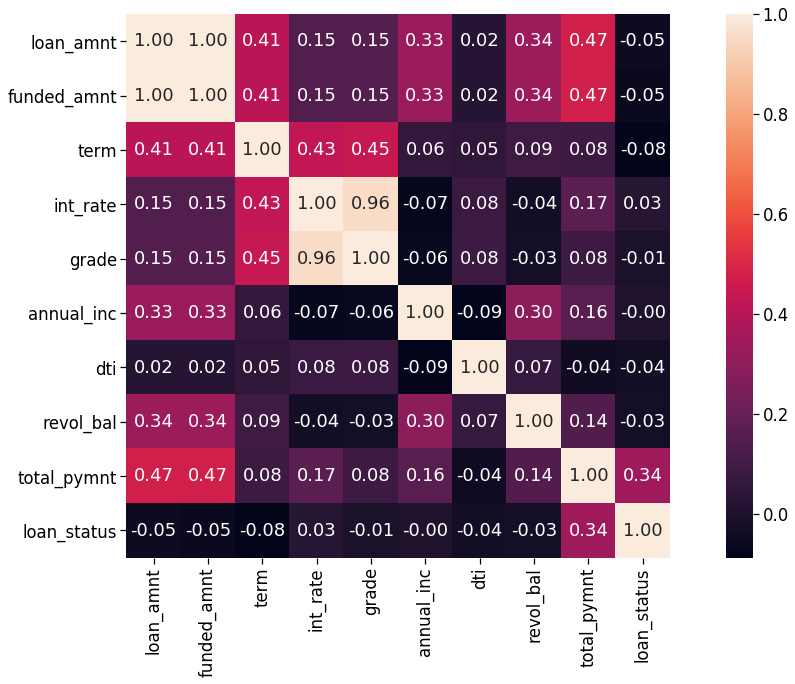

In [201]:
%matplotlib inline
plt.figure(figsize=(20,10))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(df_num.corr(), vmax=1, square=True, annot=True, fmt='.2f')

##### Summary:
<li> **loan_amnt** and **funded_amnt** have a perfect correlation of 1
<li> The second highest correlation is between **grade** and **int_rate** (0.96); this more than likely implies that one is used to determine the other
<li> **grade** is also decently correlated with **term** (0.45); regarding the last bullet, **int_rate** is also rather correlated with **term** though not identical to **grade**/**term** correlation (0.43)
<li> There is pretty strong correlation between **total_pymnt** and **loan_amnt**/**funded_amnt** (0.47)
<li> There aren't many variables that are inversely correlated with the largest being **dti** and **annual_inc** (-0.09) 

### Average Loan Amount by Grade

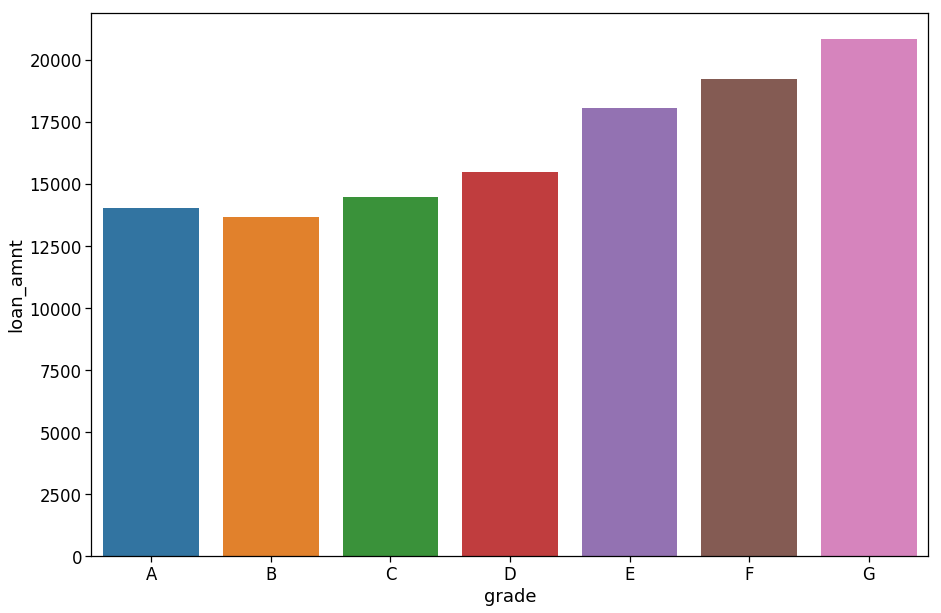

In [213]:
by_grade = df_eda.groupby('grade').mean()
avg_loan_amnt = by_grade['loan_amnt'].reset_index()
plt.subplots(figsize=(15,10))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan_amnt)

In [214]:
avg_loan_amnt.sort_values('loan_amnt', ascending=False)

,grade,loan_amnt
6,G,20855.868744
5,F,19217.782578
4,E,18071.066995
3,D,15494.357081
2,C,14480.310503
0,A,14044.276151
1,B,13650.167695


##### Summary
When looking at loan amounts (**loan_amnt**) by **grade**, we can see that riskier loans have higher average loan amounts. This seems like a recipe for disaster but at the same time, I am led to believe that **loan_amnt** is used to calculate the **grade** and higher loan amounts will result in a lower **grade**. The only outlier to this trend is that the average loan amount for grade A loans is larger than grade B loans.

### Average Total Payment by Loan Status

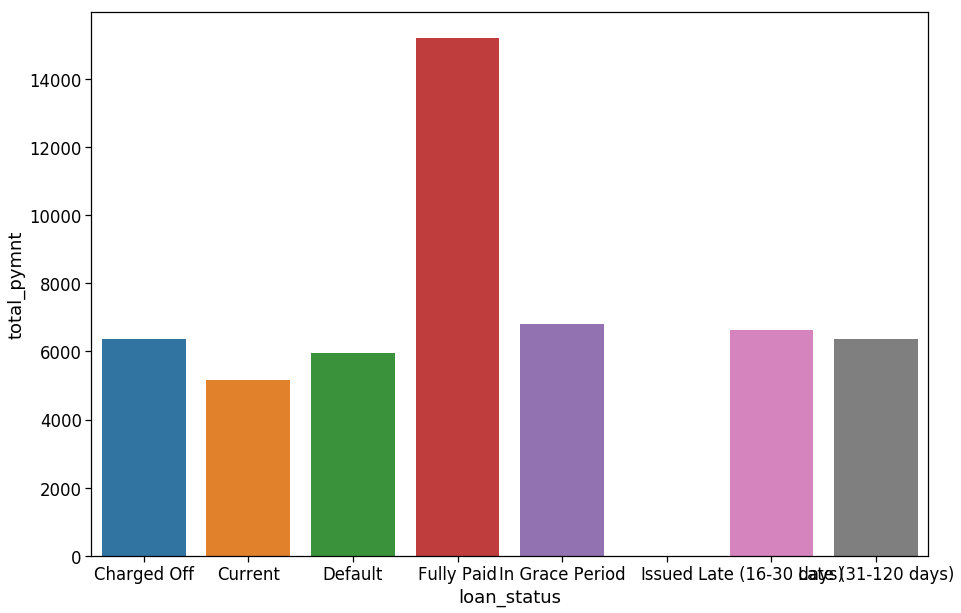

In [218]:
by_status = df_eda.groupby('loan_status').mean()
avg_total_pymnt = by_status['total_pymnt'].reset_index()
plt.subplots(figsize=(15,10))
sns.barplot(x='loan_status', y='total_pymnt', data=avg_total_pymnt)

In [220]:
avg_total_pymnt.sort_values('total_pymnt', ascending=False)

,loan_status,total_pymnt
3,Fully Paid,15186.680773
4,In Grace Period,6792.092241
6,Late (16-30 days),6617.883309
0,Charged Off,6369.612648
7,Late (31-120 days),6367.870714
2,Default,5947.982329
1,Current,5152.886189
5,Issued,9.307895


##### Summary
We dug into the total payment amount (**total_pymnt**) by **loan_status** because **total_pymnt** had the highest correlation with **loan_status** out of all variables. One can see that the Fully Paid loans have the largest average total payment. This makes perfect sense as the loans were paid off. The loans with a status indicating they are late have a higher average total payment amount than those with a status of 'Current' which is probably due to interest.

### Distribution of Loan Amount

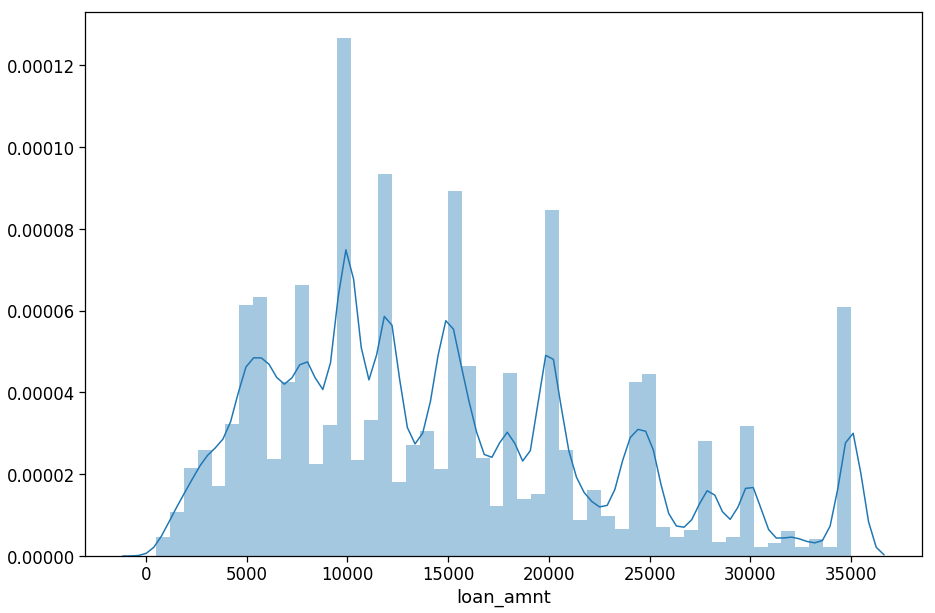

In [221]:
plt.subplots(figsize=(15,10))
sns.distplot(df['loan_amnt'])

In [227]:
from scipy.stats import skew, kurtosis
print('The skewness of ''loan_amnt'' is: {:.3f}'.format(skew(df_eda['loan_amnt'])))
print('The excess kurtosis of ''loan_amnt'' is: {:.3f}'.format(kurtosis(df_eda['loan_amnt'])))

The skewness of loan_amnt is: 0.681
The excess kurtosis of loan_amnt is: -0.259


##### Summary
<li> As seen in the **loan_amnt** distribution plot, there is tail to the right; the positive skew value of 0.681 confirms this
<li> The kurtosis value of -0.259 indicates that the peakedness is pretty close to normal

## Part 2

Create a dataset containing strictly 36 month loans.

In [230]:
df_36 = df_eda.copy()
df_36 = df_36[df_36['term'].str.contains('36')]
df_36_num = df_num.copy()
df_36_num = df_36_num[df_36_num['term'] == 36]

In [235]:
print(df_36.shape)
df_36.head()

(618687, 11)


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
5,5000.0,5000.0,36 months,7.90,A,36000.0,Dec-2011,11.20,7963.0,5631.377753,Fully Paid
7,3000.0,3000.0,36 months,18.64,E,48000.0,Dec-2011,5.35,8221.0,3938.144334,Fully Paid


In [236]:
print('Term Counts')
pd.value_counts(df_36['term']).to_frame().reset_index()

,index,term
0,36 months,618687


In [234]:
print(df_36_num.shape)
df_36_num.head()

(618687, 11)


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36,10.65,1,24000.0,2011-12-01,27.65,13648.0,5861.071414,3
2,2400.0,2400.0,36,15.96,2,12252.0,2011-12-01,8.72,2956.0,3003.653644,3
3,10000.0,10000.0,36,13.49,2,49200.0,2011-12-01,20.00,5598.0,12226.302212,3
5,5000.0,5000.0,36,7.90,0,36000.0,2011-12-01,11.20,7963.0,5631.377753,3
7,3000.0,3000.0,36,18.64,4,48000.0,2011-12-01,5.35,8221.0,3938.144334,3


In [237]:
print('Term Counts')
pd.value_counts(df_36_num['term']).to_frame().reset_index()

Term Counts


,index,term
0,36,618687


After performing sanity check, data looks good to proceed.

### #1
Percentage of loans fully paid.

In [240]:
print('Number of Fully Paid 36-month loans: ' + str(df_36[df_36['loan_status'] == 'Fully Paid']['loan_status'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_36[df_36['loan_status'] == 'Fully Paid']['loan_status'].count() / float(df_36.shape[0])))

Number of Fully Paid 36-month loans: 167575
Percentage of total loans: 27.09%


##### 27.09% of the 36-month loans have been fully paid.

### #2
Bucket by origination year and grade. Which bucket has highest rate of default?
<br>
Assume that any loan not fully paid has defaulted.

In [248]:
# Convert to date then year
df_36['orig_year'] = pd.to_datetime(df_num['issue_d'])
df_36['orig_year'] = df_36['orig_year'].apply(lambda x: x.year)

# Group year and grade
df_36['year_grade'] = df_36['orig_year'].map(str) + ' ' + df_36['grade'].map(str)

# Create default variable; if 'Fully Paid' then 'No' else 'Yes'
df_36['default'] = np.where(df_36['loan_status'] == 'Fully Paid', 'No', 'Yes')

In [269]:
df_36_default = df_36[df_36['default'] == 'Yes']
pd.value_counts(df_36_default['default']).to_frame().reset_index()

,index,default
0,Yes,451112


In [271]:
pd.value_counts(df_36_default['year_grade'], normalize=True).to_frame().reset_index().head(10)

,index,year_grade
0,2015 B,0.193065
1,2015 C,0.160016
2,2015 A,0.148515
3,2014 B,0.086963
4,2014 C,0.072113
5,2015 D,0.066977
6,2014 A,0.059129
7,2013 B,0.047252
8,2014 D,0.033814
9,2013 C,0.029966


##### Loans that originated in 2015 with a B grade constitute the largest portion of loans that have defaulted.

### #3
Bucket by origination year and grade. What annualized rate of return have the loans generated on average?
<br>
Assume that `Annualized Rate of Return = (total_pymnt / funded_amnt -1) ^ (1/3)`.

In [283]:
from __future__ import division
df_36['ann_rate'] = (df_36['total_pymnt'] / df_36['funded_amnt'] - 1) ** (1/3)

In [292]:
print('Overall average rate of return: ' + str(df_36['ann_rate'].mean()))

by_year_grade = df_36.groupby('year_grade').mean()
avg_ann_rate = by_year_grade['ann_rate'].reset_index()
avg_ann_rate.sort_values('ann_rate', ascending=False).head(10)

Overall average rate of return: 0.475485541756


,year_grade,ann_rate
33,2011 G,0.683785
40,2012 G,0.674487
26,2010 G,0.671978
39,2012 F,0.661811
38,2012 E,0.648165
32,2011 F,0.628126
31,2011 E,0.627589
11,2008 F,0.618044
37,2012 D,0.617703
12,2008 G,0.612983


##### Looking at all of the loans, the average annual rate of return was 0.475.

##### Looking at buckets, loans that originated in 2011 (0.684), 2012 (0.674), and 2010 (0.672) with a G grade had the highest average annual rates of return.